In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

from dotenv import load_dotenv
load_dotenv("../.env")
AFDB_JESS_SCAN_TABLE = os.getenv("AFDB_JESS_SCAN_TABLE")
AFDB_SCAN_SEQUENCES = os.getenv("AFDB_SCAN_SEQUENCES")
AFDB_DOMAINS = os.getenv("AFDB_DOMAINS")
TABLE_WITH_PFAM = os.getenv("TABLE_WITH_PFAM")

In [2]:
df = pd.read_csv(AFDB_JESS_SCAN_TABLE)
pdf = pd.read_csv(TABLE_WITH_PFAM)
d_df = pd.read_csv(AFDB_DOMAINS)
seq_df = pd.read_csv(AFDB_SCAN_SEQUENCES)

## Extract sequences with no Pfam annotation

In [7]:
# Simplify everything.
# Get isopep bonds with no annotations:
cond1 = (df["probability"]>.65)
cond2 = (~df["taxonomy"].isna())
cond3 = (df["pfamA_acc"].isna())
final_df = pd.merge(df[cond1&cond2&cond3], seq_df)

# Create domain boundaries
# Apply different boundaries based on average distance between bond and domain boundary
boundaries = {
    "CnaB-like": {
        "left": 10,
        "right": 5
    },
    "CnaA-like": {
        "left": 5,
        "right": 30
    }
}
final_df["seq_start"] = final_df.apply(lambda x: x["r1_bond"] - boundaries[x["bond_type"]]["left"], axis=1)
final_df.loc[final_df["seq_start"]< 0, "seq_start"] = 1
final_df["seq_end"] = final_df.apply(lambda x: x["r2_bond"] + boundaries[x["bond_type"]]["right"], axis=1)
final_df["id"] = final_df.apply(lambda x: f"{x['uniprot_acc']}_{x['seq_start']}_{x['seq_end']}", axis=1)
final_df["sequence"] = final_df.apply(lambda x: x["sequence"][x["seq_start"]:x["seq_end"]], axis=1)

# Exclude long proteins (insertions most likely)
final_df["len"] = final_df["seq_end"] - final_df["seq_start"]
final_df = final_df[final_df["len"]<300]

In [5]:
# Save sequences
with open("output/sequences.fa", "wt") as fh:
    for index, row in final_df.iterrows():
        fh.write(">{}\n{}\n".format(row["id"], row["sequence"]))

In [74]:
# Cluster with ./sh/cluster.sh
# Reformat cluster file
clus_df = pd.read_table("output/idp_cluster.tsv", names=["clus_rep", "members"])
clus_df = pd.merge(clus_df, final_df[["id", "template"]].rename(columns={"id":"members"}))
# Add pfam annot
pdf["template"] = pdf.apply(lambda x: x["PDB code"].lower()+"_"+x["Chain"]+"_"+str(x["r1_bond"])+"_"+str(x["r_cat"])+"_"+str(x["r2_bond"]), axis=1)
clus_df = pd.merge(clus_df, pdf[["template", "pfamA_acc"]], how="left", on="template")
# Collapse members and pfam annots
clus_df = pd.merge(  
    pd.merge(clus_df.groupby("clus_rep")["members"].apply(lambda x: ','.join(x)).reset_index(),
        clus_df.fillna("ND").rename(columns={"pfamA_acc":"members_template_domains"}).groupby("clus_rep")["members_template_domains"].apply(lambda x: ','.join(x)).reset_index()),
    clus_df[["clus_rep", "template", "pfamA_acc"]].rename(columns={"pfamA_acc":"template_domain"}).fillna("ND").drop_duplicates("clus_rep"), how="left")
clus_df["size"] = clus_df["members"].apply(lambda x: len(x.split(",")))
clus_df = clus_df.sort_values("size", ascending=False)
clus_df.loc["same domain"] = False
# Check if templates come from the same domain at least in 80% of the cases
clus_df.loc[clus_df["template_domain"]!="ND", "same domain"] = clus_df.loc[clus_df["template_domain"]!="ND"]\
    .apply(lambda x: check_domain_consistency(x), 
    axis=1)

clus_df[["clus_rep", "template", "template_domain", "size", "same domain", "members"]].fillna("ND").to_csv("output/clusters.csv", index=False)


In [76]:
clus_df[["clus_rep", "template", "template_domain", "size", "same domain", "members"]]

,clus_rep,template,template_domain,size,same domain,members
3821,R9MJJ6_299_464,3uxf_A_363_452_487,PF17802,298,True,"R9MJJ6_299_464,A0A3E5G7A7_368_521,A0A414S1G5_3..."
318,A0A133Z609_522_647,6m3y_A_604_658_729,ND,220,NaN,"A0A133Z609_522_647,A0A133XTH0_27_151,A0A173U6M..."
1458,A0A352DMJ3_29_183,2wza_A_1082_1132_1232,PF17998,192,True,"A0A352DMJ3_29_183,A0A3E2TH90_29_180,A0A3E2XNV8..."
1383,A0A2X3H4H2_352_488,3qe5_A_1006_1050_1121,ND,172,NaN,"A0A2X3H4H2_352_488,A0A378MFR7_355_491,A0A841ZQ..."
3388,A0A833D9R1_533_673,2f68_X_176_209_293,PF05737,157,False,"A0A833D9R1_533_673,A0A2W4PDR4_193_324,A0A2S5M5..."
...,...,...,...,...,...,...
481,A0A1F5NA19_165_257,8f70_A_299_386_437,ND,1,NaN,A0A1F5NA19_165_257
483,A0A1F5NPL9_198_353,2wza_A_1082_1132_1232,PF17998,1,True,A0A1F5NPL9_198_353
484,A0A1F5PLB7_879_1032,3opu_A_1157_1207_1307,PF17998,1,True,A0A1F5PLB7_879_1032
2188,A0A4R0DPB1_796_85,3qe5_A_1006_1050_1121,ND,1,NaN,A0A4R0DPB1_796_85


In [69]:
def check_domain_consistency(x):
    flag = False
    num_common_domains = len([i for i in str(x["members_template_domains"]).split(",") if i==x["template_domain"]])
    if num_common_domains > 0:
        fraction = num_common_domains / x["size"]
        if fraction > 0.8:
            flag = True
    return flag

In [14]:


clus_df = pd.merge(clus_df, final_df[["id", "template"]].rename(columns={"id":"clus_rep"})).sort_values("size", ascending=False)\
        [["clus_rep", "template", "size", "members"]]
clus_df.to_csv("output/clusters.csv", index=False)

## Find missing isopep bond (those not annotated in Pfam but also not detected by method above)

In [ ]:
# Why all the other unmapped sequences are not here? Shorter than 80 aa?
# Where have they gone?
# They belonged to sequences with only one or none Pfam annotation

## How to set domain boundaries?

In [10]:
test_df = df[(df["probability"]>.65)&(~df["pfamA_acc"].isna())].copy()
test_df["right_len"] = test_df["seq_end"] - test_df["r2_bond"]
test_df["left_len"] = test_df["r1_bond"] - test_df["seq_start"]

(0.0, 4000.0)

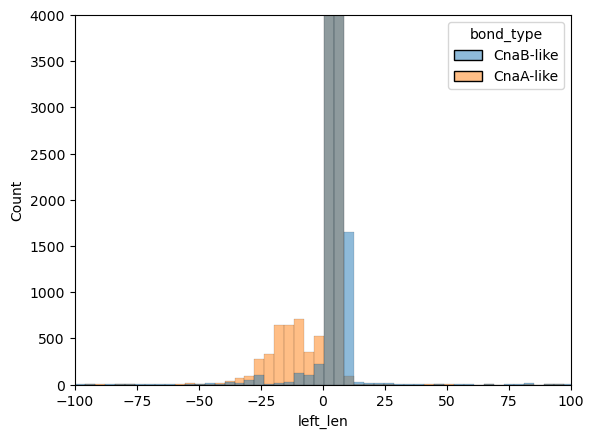

In [28]:
sns.histplot(test_df, x="left_len", hue="bond_type", bins=400)
plt.xlim([-100, 100])
plt.ylim([0,4000])

In [36]:
test_df[(test_df["left_len"]>0)&(test_df["bond_type"]=="CnaA-like")]["left_len"].describe()

count    17698.000000
mean         5.087015
std          8.326046
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max        785.000000
Name: left_len, dtype: float64

(-100.0, 100.0)

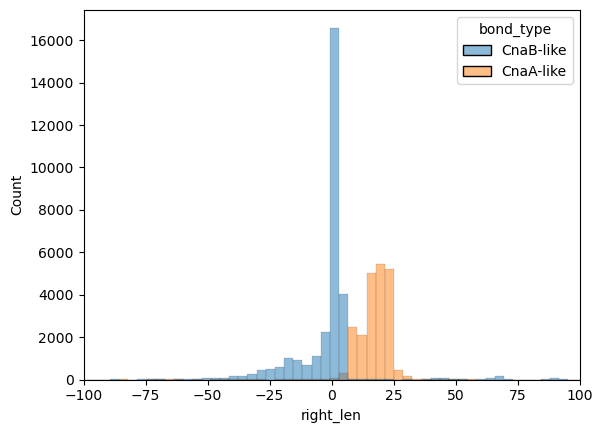

In [29]:
sns.histplot(test_df, x="right_len", hue="bond_type", bins=400)
plt.xlim([-100, 100])

In [39]:
test_df[(test_df["right_len"]>0)&(test_df["bond_type"]=="CnaB-like")]["right_len"].describe()

count    20397.000000
mean         3.883218
std         13.201357
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max        350.000000
Name: right_len, dtype: float64

In [33]:
test_df[test_df["right_len"]< 0][["uniprot_acc", "r1_bond", "r2_bond", "seq_start", "seq_end", "right_len", "left_len", "bond_type"]]

,uniprot_acc,r1_bond,r2_bond,seq_start,seq_end,right_len,left_len,bond_type
9,A0A1I1J4A2,342,459,337.0,456.0,-3.0,5.0,CnaB-like
17,A0A6N2TYG7,182,271,176.0,263.0,-8.0,6.0,CnaB-like
21,A0A6N2U3N0,41,130,35.0,123.0,-7.0,6.0,CnaB-like
38,A0A1I1XIM8,335,451,329.0,424.0,-27.0,6.0,CnaB-like
73,A0A6N2U1J3,674,795,668.0,750.0,-45.0,6.0,CnaB-like
...,...,...,...,...,...,...,...,...
623391,C2KZK5,232,372,226.0,349.0,-23.0,6.0,CnaB-like
626790,A0A385PZM4,242,375,236.0,371.0,-4.0,6.0,CnaB-like
631035,R6R6B3,667,790,661.0,761.0,-29.0,6.0,CnaB-like
631097,R5G2N0,1102,1227,1096.0,1217.0,-10.0,6.0,CnaB-like


In [ ]:
boundaries = {
    "CnaB-like": {
        "left": 10,
        "right": 5
    },
    "CnaA-like": {
        "left": 5,
        "right": 30
    }
}